In [4]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC

cancer=load_breast_cancer()
X_train,X_test,y_train,y_test=train_test_split(cancer.data,cancer.target,random_state=0)
scaler=MinMaxScaler().fit(X_train)
X_train_scaled=scaler.transform(X_train)
svm = SVC()
svm.fit(X_train_scaled,y_train)
X_test_scaled=scaler.transform(X_test)
print("svm score:{:.3f}".format(svm.score(X_test_scaled,y_test)))

svm score:0.951


# 2构建管道

In [5]:
from sklearn.pipeline import Pipeline

pipe=Pipeline([("scaler",MinMaxScaler()),("svm",SVC())])
pipe.fit(X_train,y_train)
print("pipe score:{:.3f}".format(pipe.score(X_test,y_test)))

pipe score:0.951


# 3网格搜索中使用管道

In [8]:
from sklearn.model_selection import GridSearchCV

param_grid={'svm__C':[0.001,0.01,0.1,1,10,100],
           'svm__gamma':[0.001,0.01,0.1,1,10,100]}

grid=GridSearchCV(pipe,param_grid,cv=5)
grid.fit(X_train,y_train)
print("best parameters:{}".format(grid.best_params_))
print("cross-validation score:{:.3f}".format(grid.best_score_))
print("test score:{:.3f}".format(grid.score(X_test,y_test)))

best parameters:{'svm__C': 1, 'svm__gamma': 1}
cross-validation score:0.981
test score:0.972


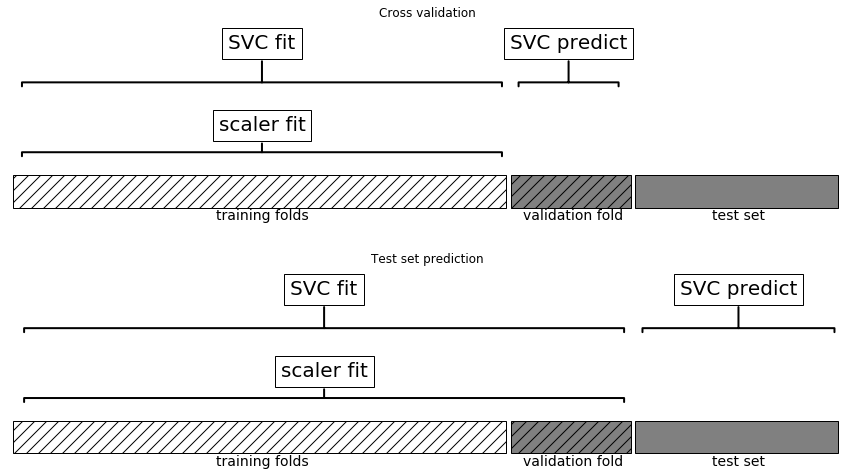

In [10]:
import mglearn

%matplotlib inline

mglearn.plots.plot_proper_processing()

# 4通用的管道接口

## 4.1使用make_pipeline方便的创建管道

In [13]:
from sklearn.pipeline import make_pipeline

pipe_long=Pipeline([("scaler",MinMaxScaler()),("svm",SVC(C=100))])
pipe_short=make_pipeline(MinMaxScaler(),SVC(C=100))

print("Pipeline steps:\n{}".format(pipe_short.steps))

Pipeline steps:
[('minmaxscaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('svc', SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))]


## 4.2访问步骤属性

In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

pipe=make_pipeline(StandardScaler(),PCA(n_components=2),StandardScaler())
print("Pipeline steps:{}".format(pipe.steps))

Pipeline steps:[('standardscaler-1', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('standardscaler-2', StandardScaler(copy=True, with_mean=True, with_std=True))]


In [15]:
pipe.fit(X_train)
components=pipe.named_steps["pca"].components_
print("PCA Components shape:{}".format(components.shape))

PCA Components shape:(2, 30)


## 4.3访问网格搜索管道中的属性

In [17]:
from sklearn.linear_model import LogisticRegression

pipe=make_pipeline(StandardScaler(),LogisticRegression())
param_grid={'logisticregression__C':[0.01,0.1,1,10,100]}
X_train,X_test,y_train,y_test=train_test_split(cancer.data,cancer.target,random_state=4)
grid=GridSearchCV(pipe,param_grid,cv=5)
grid.fit(X_train,y_train)
print("best estimator:{}".format(grid.best_estimator_))

best estimator:Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logisticregression', LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])


## 4.4网格搜索预处理步骤与模型参数

In [24]:
from sklearn.datasets import load_boston
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from matplotlib import pyplot as plt

boston=load_boston()
X_train,X_test,y_train,y_test=train_test_split(boston.data,boston.target,random_state=0)
pipe=make_pipeline(StandardScaler(),PolynomialFeatures(),Ridge())
param_grid={'polynomialfeatures__degree':[1,2,3],
           'ridge__alpha':[0.001,0.01,0.1,1,10,100]}
grid=GridSearchCV(pipe,param_grid,cv=5)
grid.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('polynomialfeatures', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('ridge', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'polynomialfeatures__degree': [1, 2, 3], 'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

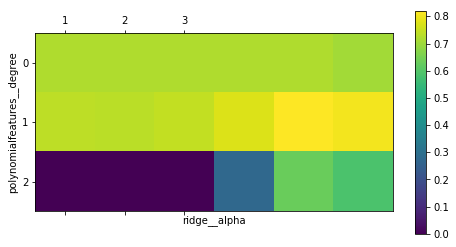

In [26]:
plt.matshow(grid.cv_results_['mean_test_score'].reshape(3,-1),vmin=0,cmap='viridis')
plt.xlabel("ridge__alpha")
plt.ylabel("polynomialfeatures__degree")
plt.xticks(range(len(param_grid['ridge__alpha'])),param_grid['ridge__alpha'])
plt.xticks(range(len(param_grid['polynomialfeatures__degree'])),param_grid['polynomialfeatures__degree'])

plt.colorbar()

## 4.5网格搜索选择使用哪个模型

In [31]:
from sklearn.ensemble import RandomForestClassifier

X_train,X_test,y_train,y_test=train_test_split(cancer.data,cancer.target,random_state=0)

pipe=Pipeline([('preprocessing',StandardScaler()),('classifier',SVC())])
param_grid=[{'preprocessing':[StandardScaler()],
            'classifier':[SVC()],
            'classifier__C':[0.001,0.01,0.1,1,10,100],
            'classifier__gamma':[0.001,0.01,0.1,1,10,100]},
           {'preprocessing':[None],
            'classifier':[RandomForestClassifier],
           'classifier__max_features':[1,2,3]}]

grid=GridSearchCV(pipe,param_grid,cv=5)
grid.fit(X_train,y_train)
print("best params:{}".format(grid.best_params_))
print("cross val score:{:.3f}".format(grid.best_score_))
print("test score:{:.3f}".format(grid.score(X_test,y_test)))

TypeError: get_params() missing 1 required positional argument: 'self'